# Data Preprocessing and Feature Extraction

#### Import libraries

In [132]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import os
import cv2
from PIL import Image, ImageOps

import matplotlib.pyplot as plt


#### Load & clean the data

In [133]:
# Load given features
features_df = pd.read_csv('data/train/features/additional_features.csv')
color_df = pd.read_csv('data/train/features/color_histogram.csv')
hog_df = pd.read_csv('data/train/features/hog_pca.csv')


In [134]:
for df in [features_df, color_df, hog_df]:
    # Check for missing values
    missing_values = sum(df.isnull().sum())
    print(missing_values)
    # Check for duplicates
    duplicates = df.duplicated().sum()
    print(duplicates)

# No missing values or duplicates in any of the dataframes


# Check all columns except the first are numeric
for df in [features_df, color_df, hog_df]:
    non_numeric_columns = [col for col in df.columns[1:] if not np.issubdtype(df[col].dtype, np.number)]
    if non_numeric_columns:
        print(f"Non-numeric columns found in {df}: {non_numeric_columns}")


0
0
0
0
0
0


### Standardise/Normalize appropriate features


In [135]:
# For the additional features, we will standardize the features

# Color histogram features look decently normalised, will edit if needed

# For HOG PCA, we will standardize the features

# scaler = StandardScaler()
# hog_df.iloc[:, 1:] = scaler.fit_transform(hog_df.iloc[:, 1:])



### Merge dataframes and add labels

In [136]:
# Merge into one dataframe (inner join because all images are in all three)
train_df = pd.read_csv('data/train/features/additional_features.csv') \
    .merge(pd.read_csv('data/train/features/color_histogram.csv'), on='image_path', how='inner') \
    .merge(pd.read_csv('data/train/features/hog_pca.csv'), on='image_path', how='inner')


# Load metadata csv
metadata_df = pd.read_csv('data/train/train_metadata.csv')
print(metadata_df.shape[0] == train_df.shape[0])

# Merge with metadata to find the labels
train_df = train_df.merge(metadata_df, on='image_path', how='inner')


True


## Shape Feature Extraction

In [137]:
# Loads images from a folder
def load_images(folder_path):
    images = []
    image_names = []
    for filename in sorted(os.listdir(folder_path)):
        # If the filename is not a jpg skip it
        if not filename.endswith('.jpg'):
            continue
        img = cv2.imread(os.path.join(folder_path, filename))
        images.append(np.array(img))
        image_names.append(filename)
    return images, image_names

# Load images from the train folder
train_images, image_names = load_images('data/train')





In [138]:
# Look at image sizes and pick a good size
# Uncomment to see my reasoning
# Look at our image sizes
def inspect_image_sizes(folder_path):
    sizes = []
    for filename in os.listdir(folder_path):
        if not filename.endswith('.jpg'):
            continue
        img = cv2.imread(os.path.join(folder_path, filename))
        if img is not None:
            sizes.append(img.shape[:2])
    return sizes

# image_sizes = inspect_image_sizes('data/train')
# print(f"Unique image sizes: {set(image_sizes)}")

In [139]:
# Resize all images to 64x64 using Pillow
# Function adds padding to ensure aspect ratio is kept
def resize_images(train_images):
    resized_images = []
    for image in train_images:
        # Convert OpenCV image to Pillow Image
        pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        # Resize to 64x64 while maintaining aspect ratio
        resized_image = ImageOps.pad(pil_image, (64, 64), color=(0, 0, 0))

        # Convert back to OpenCV format (
        resized_image = cv2.cvtColor(np.array(resized_image), cv2.COLOR_RGB2BGR)

        # Add to the resized images list
        resized_images.append(resized_image)

    return resized_images

resized_images = resize_images(train_images)

# Convert into a DataFrame
train_images_df = pd.DataFrame({
    'image_path': image_names,
    'image_array': resized_images
})


In [140]:
# Normalize the images and store in a new column
train_images_df['norm_image_array'] = train_images_df['image_array'].apply(
    lambda img: cv2.normalize(img, None, 0, 1, cv2.NORM_MINMAX)
)

Fix issues with lighting and contrast

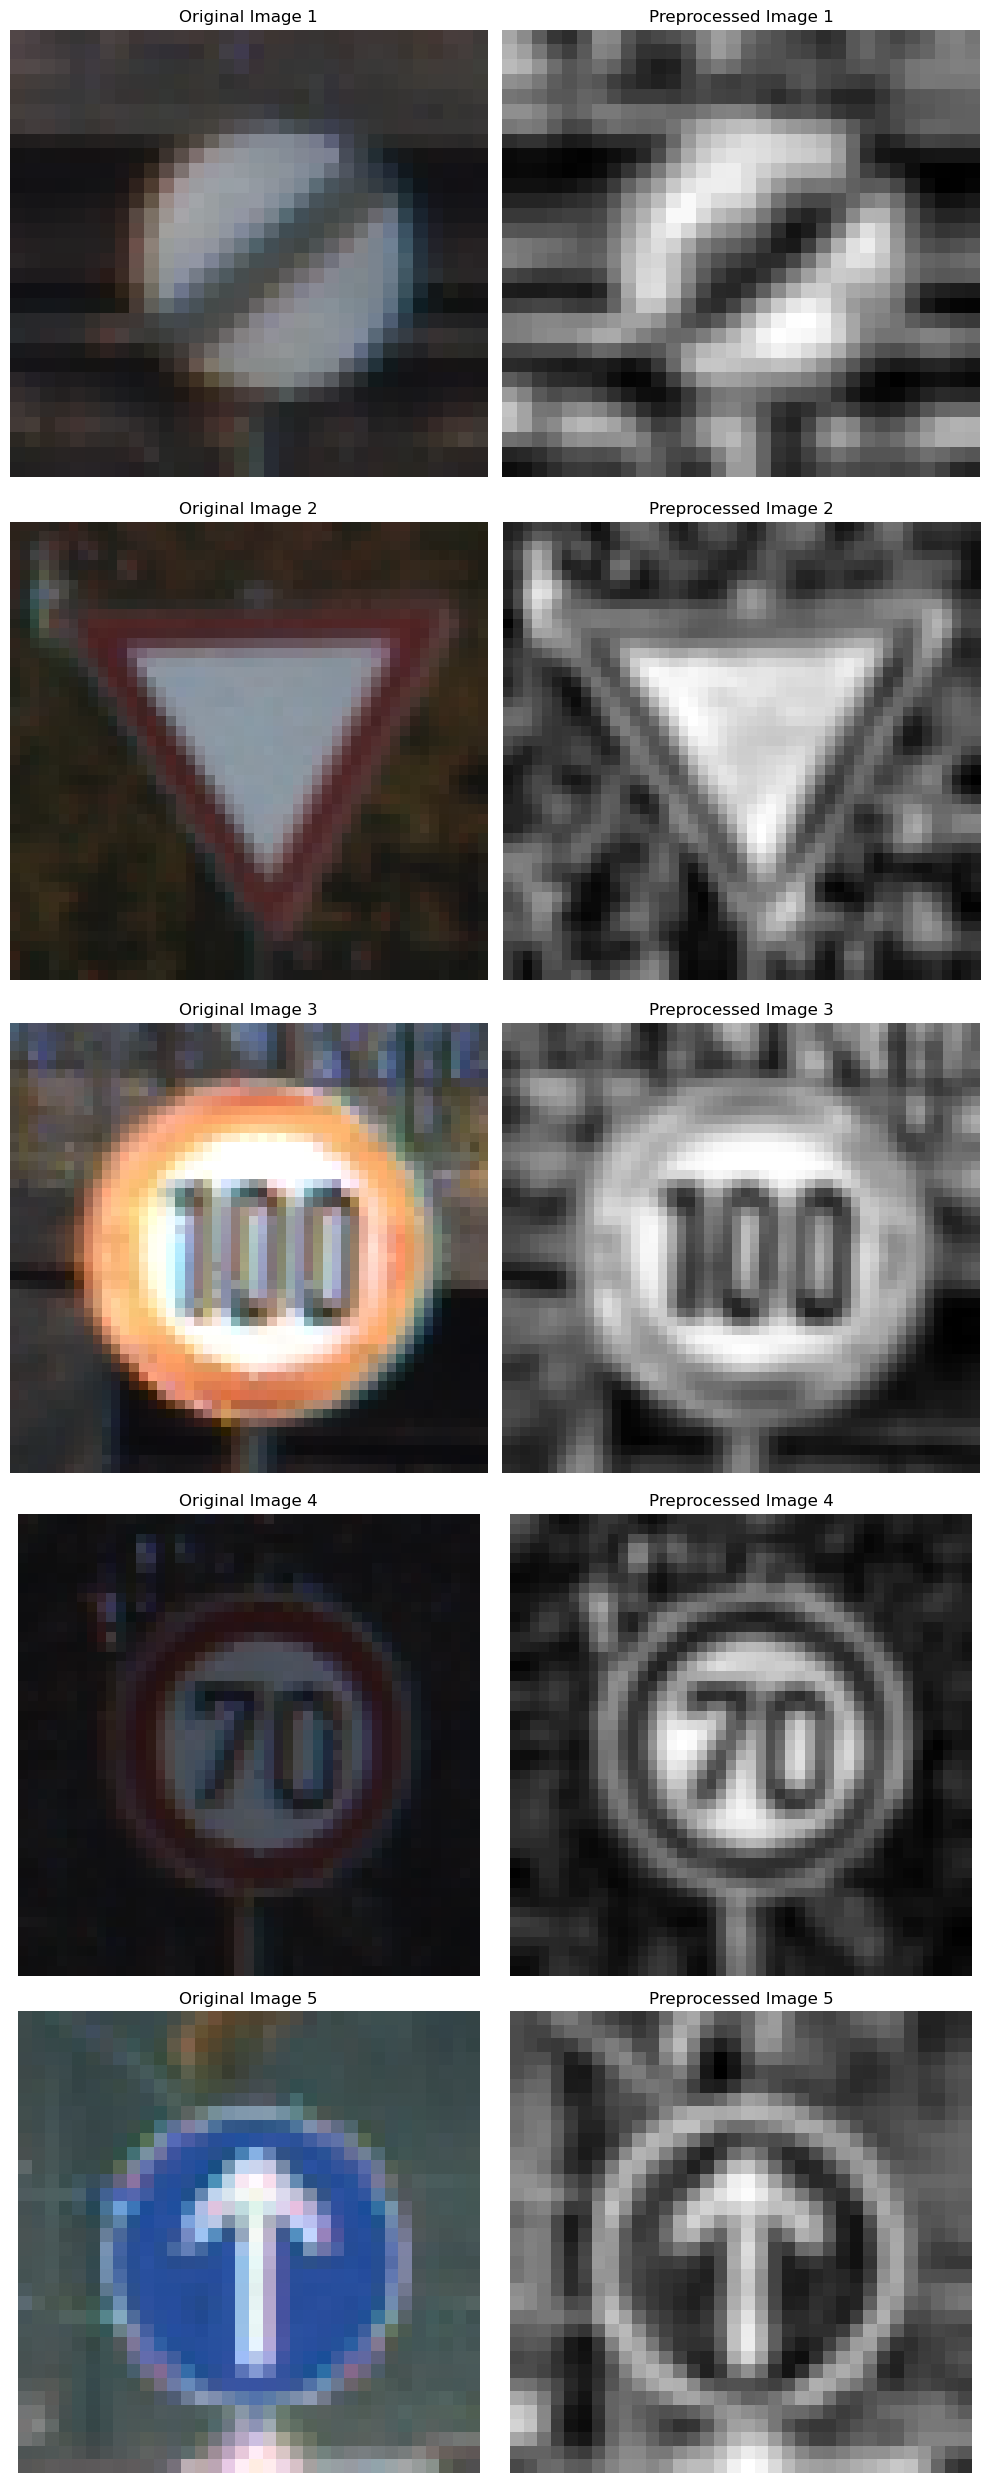

In [141]:
# Converts images to greyscale, enhances contrast and corrects brightness
def preprocess_images_shape(train_images):
    processed = []
    for image in train_images:
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply CLAHE to correct contrasts
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)

        # Apply Gaussian blur
        blurred = cv2.GaussianBlur(enhanced, (3,3), 0)
        processed.append(blurred)

    return processed

shape_preprocessed = preprocess_images_shape(train_images)

# Plot for parameter tweaking


def plot_preprocessed_images(original_images, preprocessed_images, num_images=5):
    num_images = min(num_images, len(original_images))
    plt.figure(figsize=(10, 5 * num_images))

    for i in range(num_images):
        # Plot original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB))
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        # Plot preprocessed image
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(preprocessed_images[i], cmap='gray')
        plt.title(f"Preprocessed Image {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Plot the original and preprocessed images
plot_preprocessed_images(train_images, shape_preprocessed, num_images=5)



### Find shapes of main features

First Extract Contours

In [142]:
# Apply grayscale, blur and edge detection to find contours
def isolate_contours(processed_images):
    contours_list =[]
    for image in train_images:
        # Apply Canny edge detection
        edges = cv2.Canny(image, 100, 250)

        # Use median intensity to set thresholds for Canny edge detection
        median_intensity = np.median(image)
        lower_threshold = int(max(0, 0.5 * median_intensity))
        upper_threshold = int(min(255, 1.5 * median_intensity))
        edges = cv2.Canny(image, lower_threshold, upper_threshold)


        # Find contours
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        contours_list.append(contours)
    return contours_list

# Extract contours
contours_list = isolate_contours(shape_preprocessed)


In [143]:
import cv2
import matplotlib.pyplot as plt

def plot_contours(train_images, contours_list):
    """
    Plots the contours on the original images.

    Parameters:
        train_images (list): List of original images.
        contours_list (list): List of contours for each image.
    """
    for i, (image, contours) in enumerate(zip(train_images, contours_list)):
        # Create a copy of the image to draw contours
        image_with_contours = image.copy()

        # Draw contours on the image
        cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)

        # Convert BGR to RGB for plotting
        image_with_contours = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)

        # Plot the image with contours
        plt.figure(figsize=(6, 6))
        plt.title(f"Image {i+1} with Contours")
        plt.imshow(image_with_contours)
        plt.axis('off')
        plt.show()



### Plot contours
# plot_contours(train_images, contours_list)

#### Cluster contours

### Hu moments

In [144]:
# Weighted moment of the image pixel's, good for shape recognition for possibly distorted images


def calculate_hu_moments(images):
    """Takes preprocessed images and returns Hu moments"""
    hu_moments_list = []
    for image in images:
        # Calculate moments
        moments = cv2.moments(image)

        # Calculate Hu moments
        hu_moments = cv2.HuMoments(moments).flatten()

        # Log-transform Hu Moments (normalise)
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments) + 1e-10)
        hu_moments_list.append(hu_moments)

    return hu_moments_list


# Use our shape preprocessed images
hu_moments_list = calculate_hu_moments(shape_preprocessed)


# Save Hu moments to train_df (7 Hu moments = 7 columns)
# Convert Hu moments list to a DataFrame
hu_moments_df = pd.DataFrame(hu_moments_list, columns=[f"Hu_{i+1}" for i in range(7)])

# Ensure the number of rows matches between train_df and hu_moments_df
assert len(train_df) == len(hu_moments_df), "Mismatch in number of rows between train_df and Hu moments."

# Concatenate Hu moments with train_df
train_df = pd.concat([train_df, hu_moments_df], axis=1)


train_df.head()


,image_path,edge_density,mean_b,mean_g,mean_r,ch_0,ch_1,ch_2,ch_3,ch_4,...,hog_pca_19,id,ClassId,Hu_1,Hu_2,Hu_3,Hu_4,Hu_5,Hu_6,Hu_7
0,img_000001.jpg,0.050293,63.748291,62.107910,62.850830,0.000000,0.000000,0.268901,0.355617,0.511548,...,0.271686,7218,32,2.870604,8.658513,9.999941,9.996586,10.0,-10.000000,10.0
1,img_000002.jpg,0.034424,48.680664,52.872314,61.539307,0.000000,0.002267,0.657901,0.641467,0.222700,...,0.471807,6333,13,2.822350,8.172468,9.963540,9.954407,-10.0,-9.999999,-10.0
2,img_000003.jpg,0.126709,99.174561,110.774658,127.348389,0.002243,0.143541,0.385766,0.091956,0.066163,...,-0.205895,6867,7,2.946656,7.955466,9.924310,9.997588,10.0,-10.000000,10.0
3,img_000004.jpg,0.026123,30.493896,26.616211,29.006592,0.000000,0.096069,0.947646,0.217350,0.160404,...,0.586276,7730,4,2.740183,8.395487,9.907872,9.986086,-10.0,-9.999999,10.0
4,img_000005.jpg,0.106934,116.836670,97.684814,79.495605,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.292198,6338,35,2.856199,8.690357,9.998780,9.999648,-10.0,-10.000000,-10.0


In [145]:
# Save Hu moments to train_df (7 Hu moments = 7 columns)
# Convert Hu moments list to a DataFrame
hu_moments_df = pd.DataFrame(hu_moments_list, columns=[f"Hu_{i+1}" for i in range(7)])

# Ensure the number of rows matches between train_df and hu_moments_df
assert len(train_df) == len(hu_moments_df), "Mismatch in number of rows between train_df and Hu moments."

# Concatenate Hu moments with train_df
train_df = pd.concat([train_df, hu_moments_df], axis=1)

### Edge orientation histogram

In [146]:
def get_edge_orientation_histograms(images, num_bins):
    """ Compute edge orientation histograms for a list of images.
        uses the orientation of the pixel gradients to create a histogram"""

    hist_list = []
    for image in images:
        # Compute gradients in x and y directions
        grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

        # Compute gradient magnitude
        magnitude = np.sqrt(grad_x**2 + grad_y**2)
        # Compute direction in degrees
        angle = np.arctan2(grad_y, grad_x) * 180 / np.pi

        # Normalize to 0-180 degree range
        angle = (angle + 180) % 180

        # Create histogram weighted by magnitude
        hist, _ = np.histogram(angle, bins=num_bins, range=(0, 180), weights=magnitude)

        # Normalize histogram
        hist = hist / (np.sum(hist) + 1e-6)

        # Add to the list
        hist_list.append(hist)

    return hist_list



In [147]:
# Get edge orientation histograms
num_bins = 8
edge_orientation_histograms = get_edge_orientation_histograms(shape_preprocessed, num_bins=num_bins)

# Convert to df
edge_hist_columns = [f"Edge_Hist_Bin_{i+1}" for i in range(num_bins)]
edge_hist_df = pd.DataFrame(edge_orientation_histograms, columns=edge_hist_columns)

# Concatenate the edge histograms with train_df
train_df = pd.concat([train_df, edge_hist_df], axis=1)

train_df.head()


,image_path,edge_density,mean_b,mean_g,mean_r,ch_0,ch_1,ch_2,ch_3,ch_4,...,Hu_6,Hu_7,Edge_Hist_Bin_1,Edge_Hist_Bin_2,Edge_Hist_Bin_3,Edge_Hist_Bin_4,Edge_Hist_Bin_5,Edge_Hist_Bin_6,Edge_Hist_Bin_7,Edge_Hist_Bin_8
0,img_000001.jpg,0.050293,63.748291,62.107910,62.850830,0.000000,0.000000,0.268901,0.355617,0.511548,...,-10.000000,10.0,0.092945,0.124469,0.163909,0.191622,0.235562,0.066152,0.063978,0.061363
1,img_000002.jpg,0.034424,48.680664,52.872314,61.539307,0.000000,0.002267,0.657901,0.641467,0.222700,...,-9.999999,-10.0,0.171286,0.143202,0.086950,0.100560,0.135598,0.071550,0.167579,0.123275
2,img_000003.jpg,0.126709,99.174561,110.774658,127.348389,0.002243,0.143541,0.385766,0.091956,0.066163,...,-10.000000,10.0,0.183704,0.086823,0.091119,0.135026,0.162364,0.126679,0.091064,0.123221
3,img_000004.jpg,0.026123,30.493896,26.616211,29.006592,0.000000,0.096069,0.947646,0.217350,0.160404,...,-9.999999,10.0,0.168544,0.118900,0.083321,0.113685,0.132372,0.109634,0.119196,0.154347
4,img_000005.jpg,0.106934,116.836670,97.684814,79.495605,0.000000,0.000000,0.000000,0.000000,0.000000,...,-10.000000,-10.0,0.206317,0.108894,0.115447,0.084715,0.113734,0.108388,0.120409,0.142096


## Colour feature extraction

### HSV Histogram + mean and variation

In [148]:
# Separates color from intensity so good for low light color features

# Extract HSV features from images
def extract_hsv_features(images):

    hsv_features_list = []

    for image in images:
        # Convert to HSV
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        # Split into HSV channels
        h, s, v = cv2.split(hsv)

        # Apply CLAHE to value channel
        clahe = cv2.createCLAHE(clipLimit=1.5, tileGridSize=(6,6))
        v_eq = clahe.apply(v)

        hsv_eq = cv2.merge((h, s, v_eq))

        h,s,v = cv2.split(hsv_eq)

        # Mean and std var for each channel
        hsv_features = [
            np.mean(h), np.std(h),
            np.mean(s), np.std(s),
            np.mean(v), np.std(v)
        ]

        # Add HSV histogram

        for channel in [h,s,v]:
            # Get the histogram for the channel
            hist = cv2.calcHist([channel], [0], None, [32], [0, 256])
            # Normalize and flatten
            hist = cv2.normalize(hist, hist).flatten()
            hsv_features.extend(hist)

        # Append features to the list
        hsv_features_list.append(hsv_features)

    return np.array(hsv_features_list)




In [149]:
# Extract HSV features
hsv_features = extract_hsv_features(train_images)
print(hsv_features.shape)

# For 32 bins
columns = [f"{channel}_mean" for channel in ['H', 'S', 'V']] + \
          [f"{channel}_std" for channel in ['H', 'S', 'V']] + \
          [f"{channel}_hist_bin_{i+1}" for channel in ['H', 'S', 'V'] for i in range(32)]


# Convert HSV features to DataFrame
hsv_features_df = pd.DataFrame(hsv_features, columns=columns)

# Add to train_df
train_df = pd.concat([train_df, hsv_features_df], axis=1)


(5488, 102)


In [150]:
train_df.head()

,image_path,edge_density,mean_b,mean_g,mean_r,ch_0,ch_1,ch_2,ch_3,ch_4,...,V_hist_bin_23,V_hist_bin_24,V_hist_bin_25,V_hist_bin_26,V_hist_bin_27,V_hist_bin_28,V_hist_bin_29,V_hist_bin_30,V_hist_bin_31,V_hist_bin_32
0,img_000001.jpg,0.050293,63.748291,62.107910,62.850830,0.000000,0.000000,0.268901,0.355617,0.511548,...,0.116459,0.096205,0.081015,0.086078,0.131649,0.086078,0.050634,0.015190,0.015190,0.000000
1,img_000002.jpg,0.034424,48.680664,52.872314,61.539307,0.000000,0.002267,0.657901,0.641467,0.222700,...,0.060679,0.134632,0.155491,0.073953,0.054991,0.022755,0.000000,0.000000,0.000000,0.000000
2,img_000003.jpg,0.126709,99.174561,110.774658,127.348389,0.002243,0.143541,0.385766,0.091956,0.066163,...,0.070751,0.068982,0.102589,0.086670,0.086670,0.091976,0.093745,0.132658,0.113202,0.688055
3,img_000004.jpg,0.026123,30.493896,26.616211,29.006592,0.000000,0.096069,0.947646,0.217350,0.160404,...,0.040442,0.008987,0.002996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,img_000005.jpg,0.106934,116.836670,97.684814,79.495605,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.057561,0.115123,0.080586,0.088261,0.072911,0.084423,0.042212,0.069074,0.034537,0.053724


## Save the final dataframe